In [1]:
from dictionaries import *
from helper_functions import *
from produce_datasets import *
import pandas as pd
import numpy as np
pd.options.display.max_columns = None

In [2]:
def add_qtrid(df):
    '''
    adds a column for the year and quarter.

    params: df(dataframe)
    returns: dataframe with column added'''
    df['qtrid'] = df['year'] + (df['qtr']/4)
    return df

def import_one(year):
    '''brings a single year's woth of data into a dataframe. Used for initial EDA. 
    Referenced in import_all

    params: year(str)
    returns: df(dataframe)'''
    filepath = '../data/area_files/' + str(year) + '.csv'
    #all relevant csvs are renamed with only the year
    df = pd.read_csv(filepath, dtype = schema_dict)
    #schema_dict is found in dictionaries.py
    for column in drop_columns:
        if column in df.columns:
            df = df.drop([column], axis = 1)
    return df

def import_all(years):
    '''combines as many years of data into a single dataframe, as well as adding quater id
    References import_one and add_qtrid

    params: years (list of str)
    returns: df (dataframe)'''
    df = import_one(years[0])
    for year in years[1:]:
        df = df.append(import_one(year))
    df = add_qtrid(df)
    return df

In [3]:
def create_timeline_2001(variable):
    '''produces a dataframe of the 2001 recession timeline.
    
    .0Used to compute targets

    params: variable, str, one of ['month3_emplvel' (employment), 'avg_wkly_wage' (wages)]
    returns: df, Dataframe
    exports a json file (used in plotting results)
    '''
    
    #create a dataframe of the years in question
    df = import_all(recession1_years)

    #drop 'unknown or undefined' areas
    df = df[~df['area_fips'].str.contains("999")]
    
    #pivots the table to arrange quarters in columns, drops extraneous variables.
    df = df.pivot_table(columns = 'qtrid', values = variable, index = ['area_fips', 'area_title'], aggfunc = np.sum)
    df = df.reset_index()
    
    #fill nans
    df = df.fillna(0)

    #creates a secondary dataframe with only timeline variables
    df2 = df.drop(columns = ['area_fips', 'area_title'])
    df2 = df2.reset_index()
    
    #drops the index so that all calculations are free of any type mismatches
    df2 = df2.drop(columns = 'index')
    df2 = df2.fillna(0)

### DEPRECIATED CODE #### 

#     #this specifies when the jobs numbers "bottom-out" during the recession
#     nadir = df2.iloc[:,6:].apply(lambda x: calc_nadir(x), axis=1).rename('nadir')
    
#     #counts the number of quarters to the nadir since the beginning of the timeframe
#     nadir_qtr = df2.iloc[:,6:].apply(lambda x: calc_nadir_qtr(x), axis=1).rename('nadir_qtr')
    
#     #computes the highest points before and after the nadir, and captures the quarter count
#     pre_peak = df2.apply(lambda x: calc_pre_peak(x), axis=1).rename('pre_peak')
#     pre_peak_qtr = df2.apply(lambda x: calc_pre_peak_quarter(x), axis=1).rename('pre_peak_qtr')
#     post_peak = df2.apply(lambda x: calc_post_peak(x), axis=1).rename('post_peak')
#     post_peak_qtr = df2.apply(lambda x: calc_post_peak_qtr(x), axis=1).rename('post_peak_qtr')

### DEPRECIATED CODE #### 
    
    #specifies the lowest job numbers during the recession. Disregards quarters before the recession event. 
    df2['nadir'] = df2.iloc[:,6:].min(axis=1)

    #specifies which quarter the nadir occured.
    df2['nadir_qtr'] = df2.iloc[:,6:].idxmin(axis=1).apply(lambda x: df.columns.get_loc(x))
    
    #creates a column to store indices for lookup.
    df2['new'] = [df2.iloc[i].values for i in df.index]
  
    #specifies the highest job numbers *before* the nadir.
    df2['pre_peak'] = df2.apply(lambda x: max(x['new'][0:x['nadir_qtr']]), axis=1)
    
    #creates a column to derive the recovery quarter
    df2['recovery_list'] = df2.apply(lambda x: (x['new'][x['nadir_qtr']:] > x['pre_peak']), axis=1)

    # df2['recovery_qtr'] = next((i for i, j in enumerate(list(df2['recovery_list'])) if j), None)

    #specifies the highest job numbers *after* the nadir
    df2['post_peak'] = df2.apply(lambda x: max(x['new'][x['nadir_qtr']:]), axis=1)
    
    #specifies which quarter the pre-peak occurred.
    df2['pre_peak_qtr'] = pd.Series([s[i] for i, s in zip(df2.index, df2['pre_peak'].apply(
        lambda x: [i for i in (df2.iloc[:,0:-6] == x)
                   .idxmax(axis=1)]))]).apply(lambda x: df2.columns.get_loc(x))
    
    #specifies which quarter the post-peak occurred.
    df2['post_peak_qtr'] = pd.Series([s[i] for i, s in zip(df2.index, df2['post_peak'].apply(
        lambda x: [i for i in (df2.iloc[:,0:-6] == x)
                   .idxmax(axis=1)]))]).apply(lambda x: df2.columns.get_loc(x))
    
    #creates a new dataset to store derived fields
    df_new = df2[['nadir', 'nadir_qtr', 'pre_peak', 'pre_peak_qtr', 'recovery_list', 'post_peak', 'post_peak_qtr', 'new']]
    
    #puts the computed points in a dataframe, joins with timeline
    df = df.join(df_new, how = 'outer', rsuffix = '_derive')
    
    #PRIMARY TARGET: did the area decline the entire time(-1), did it start growing again but not avhieve it's former numbers(0), or did it grow and recover(1)?
    df['recovery'] = (df['post_peak'] >= df['pre_peak']) *1

    #SECONDARY TARGET: How long did the jobs numbers decline?
    df['decline'] = (df['nadir_qtr'] - df['pre_peak_qtr'])
    
    #TERTIARY TARGET: different in before/after jobs numbers
    df['delta'] = df['post_peak'] - df['pre_peak']
    
    #export the data
    # df.to_json('data/Recession1_timeline.json')
    return df

In [4]:
df = create_timeline_2001('month3_emplvl')
    

In [5]:
    # df2['recovery_list'] = df2.apply(lambda x: (x['new'][x['nadir_qtr']:] > x['pre_peak']), axis=1)

    # df2['recovery_qtr'] = list(df2['recovery_list']).index(next(filter(lambda i: i != 0, list(df2['recovery_list'])))) 

In [6]:
df_samp = df[df['recovery'] == 1].sample(10, random_state = 7)

In [7]:
df_samp['recovery_qtr'] = df_samp['recovery_list'].apply(lambda x: list(x).index(True))
df_samp['recovery_qtr'] = df_samp['recovery_qtr'] + df_samp['nadir_qtr']

In [8]:
df_samp

qtrid,area_fips,area_title,2000.25,2000.5,2000.75,2001.0,2001.25,2001.5,2001.75,2002.0,2002.25,2002.5,2002.75,2003.0,2003.25,2003.5,2003.75,2004.0,2004.25,2004.5,2004.75,2005.0,2005.25,2005.5,2005.75,2006.0,2006.25,2006.5,2006.75,2007.0,2007.25,2007.5,2007.75,2008.0,nadir,nadir_qtr,pre_peak,pre_peak_qtr,recovery_list,post_peak,post_peak_qtr,new,recovery,decline,delta,recovery_qtr
1374,27075,"Lake County, Minnesota",7518.0,8346.0,8642.0,7714.0,8154.0,9012.0,8818.0,8174.0,7642.0,8288.0,8840.0,8022.0,7854.0,8876.0,8642.0,7926.0,7838.0,9020.0,8644.0,8130.0,8060.0,8968.0,8694.0,8314.0,8182.0,9344.0,8810.0,8202.0,8214.0,9352.0,8898.0,8346.0,7642.0,10,9012.0,5,"[False, False, False, False, False, False, Fal...",9352.0,29,"[7518.0, 8346.0, 8642.0, 7714.0, 8154.0, 9012....",1,5,340.0,17
3073,54063,"Monroe County, West Virginia",3812.0,4126.0,4072.0,4040.0,3894.0,4062.0,4086.0,4060.0,3950.0,4122.0,4014.0,3906.0,3772.0,3912.0,4032.0,3996.0,4112.0,4224.0,4242.0,4232.0,3962.0,4138.0,4090.0,4086.0,3978.0,4096.0,4070.0,4196.0,4138.0,4134.0,4210.0,4158.0,3772.0,14,4126.0,1,"[False, False, False, True, True, True, False,...",4242.0,18,"[3812.0, 4126.0, 4072.0, 4040.0, 3894.0, 4062....",1,13,116.0,17
1919,36119,"Westchester County, New York",794524.0,820670.0,813970.0,837170.0,807890.0,829618.0,805440.0,823416.0,799696.0,822272.0,807492.0,829566.0,800922.0,822528.0,805160.0,826352.0,808770.0,832592.0,819536.0,842588.0,813082.0,838078.0,823780.0,841502.0,815112.0,842546.0,827984.0,851376.0,830014.0,862302.0,840974.0,865742.0,799696.0,10,837170.0,3,"[False, False, False, False, False, False, Fal...",865742.0,31,"[794524.0, 820670.0, 813970.0, 837170.0, 80789...",1,7,28572.0,19
3103,55011,"Buffalo County, Wisconsin",8747.0,9320.0,9322.0,9298.0,9824.0,9445.0,9488.0,9910.0,9768.0,9142.0,10028.0,9060.0,9944.0,9583.0,10390.0,9256.0,9702.0,9462.0,9957.0,10740.0,10502.0,11230.0,11106.0,11158.0,11662.0,12302.0,12298.0,11267.0,10292.0,10938.0,10726.0,10450.0,9060.0,13,10028.0,10,"[False, True, False, False, False, False, True...",12302.0,25,"[8747.0, 9320.0, 9322.0, 9298.0, 9824.0, 9445....",1,3,2274.0,14
3683,C2706,"Ithaca, NY MSA",92042.0,95082.0,93852.0,94730.0,92978.0,96624.0,94556.0,95156.0,92922.0,95148.0,95666.0,96214.0,95192.0,97904.0,97330.0,97772.0,96510.0,98820.0,98532.0,99160.0,100396.0,100062.0,99060.0,99840.0,97912.0,100914.0,99772.0,101050.0,98418.0,101806.0,101344.0,102708.0,92922.0,10,96624.0,5,"[False, False, False, True, True, True, False,...",102708.0,31,"[92042.0, 95082.0, 93852.0, 94730.0, 92978.0, ...",1,5,6084.0,13
2365,45019,"Charleston County, South Carolina",362554.0,378358.0,362860.0,369826.0,362656.0,364742.0,360836.0,359780.0,358752.0,370100.0,368878.0,369464.0,369964.0,377104.0,376108.0,378814.0,379144.0,389946.0,389044.0,391862.0,388852.0,402586.0,398644.0,398042.0,396874.0,406484.0,410372.0,416576.0,417812.0,427552.0,424776.0,424316.0,358752.0,10,378358.0,1,"[False, False, False, False, False, True, True...",427552.0,29,"[362554.0, 378358.0, 362860.0, 369826.0, 36265...",1,9,49194.0,15
3448,C1722,"Clarksburg, WV MicroSA",35242.0,36634.0,36225.0,36026.0,35447.0,36476.0,35968.0,36227.0,35571.0,36785.0,36377.0,36863.0,35954.0,37505.0,37048.0,37325.0,36400.0,37701.0,37407.0,37503.0,36407.0,37653.0,37616.0,37383.0,36977.0,37625.0,37037.0,37227.0,36265.0,37617.0,37227.0,37570.0,35571.0,10,36785.0,9,"[False, True, False, True, True, True, False, ...",37701.0,17,"[35242.0, 36634.0, 36225.0, 36026.0, 35447.0, ...",1,1,916.0,11
3297,C1086,"Alice, TX MicroSA",13001.0,13245.0,13460.0,13800.0,13642.0,14243.0,14145.0,14031.0,13873.0,14086.0,14208.0,14106.0,14522.0,14855.0,14959.0,15120.0,15105.0,15492.0,15554.0,15695.0,15517.0,15713.0,15970.0,15874.0,16127.0,16666.0,16778.0,16876.0,17380.0,18144.0,18178.0,17937.0,13873.0,10,14243.0,5,"[False, False, True, True, True, True, True, T...",18178.0,30,"[13001.0, 13245.0, 13460.0, 13800.0, 13642.0, ...",1,5,3935.0,12
742,18063,"Hendricks County, Indiana",58656.0,60586.0,60618.0,60272.0,59964.0

In [9]:
import matplotlib.pyplot as plt 
%matplotlib inline



In [10]:
df_samp.columns

Index([    'area_fips',    'area_title',         2000.25,          2000.5,
               2000.75,          2001.0,         2001.25,          2001.5,
               2001.75,          2002.0,         2002.25,          2002.5,
               2002.75,          2003.0,         2003.25,          2003.5,
               2003.75,          2004.0,         2004.25,          2004.5,
               2004.75,          2005.0,         2005.25,          2005.5,
               2005.75,          2006.0,         2006.25,          2006.5,
               2006.75,          2007.0,         2007.25,          2007.5,
               2007.75,          2008.0,         'nadir',     'nadir_qtr',
            'pre_peak',  'pre_peak_qtr', 'recovery_list',     'post_peak',
       'post_peak_qtr',           'new',      'recovery',       'decline',
               'delta',  'recovery_qtr'],
      dtype='object', name='qtrid')

In [11]:
df_plot = df_samp.drop(columns = ['area_fips', 'area_title', 'nadir',
           'nadir_qtr',      'pre_peak',  'pre_peak_qtr', 'recovery_list',
           'post_peak', 'post_peak_qtr',           'new',      'recovery',
             'decline',         'delta',  'recovery_qtr'])



In [12]:
df_samp['area_title'].iloc[0]

'Lake County, Minnesota'

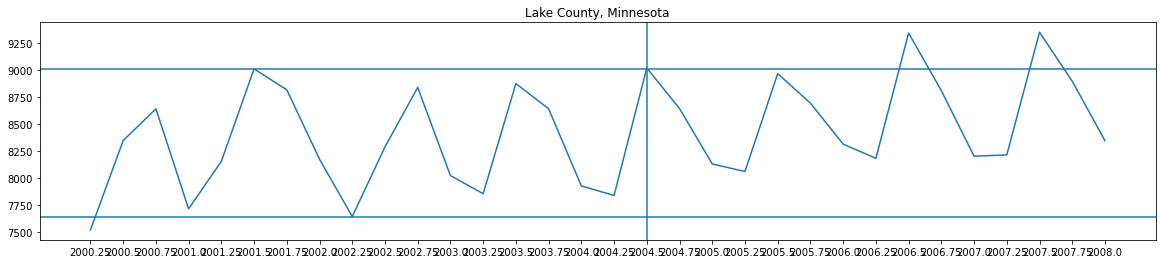

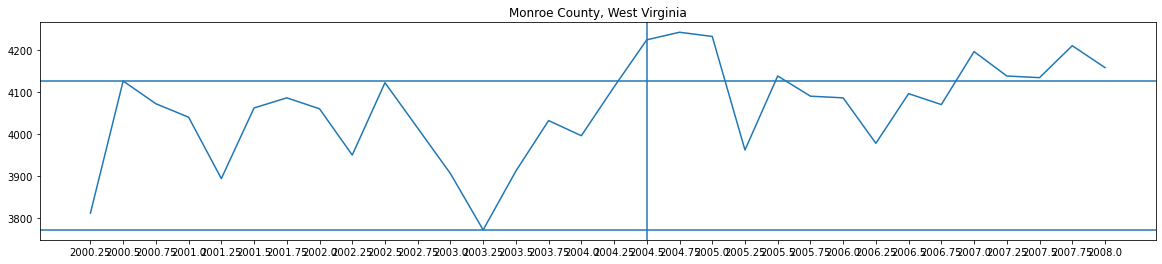

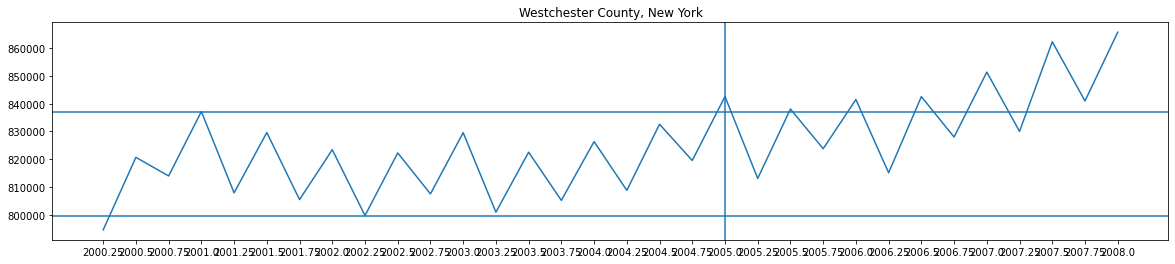

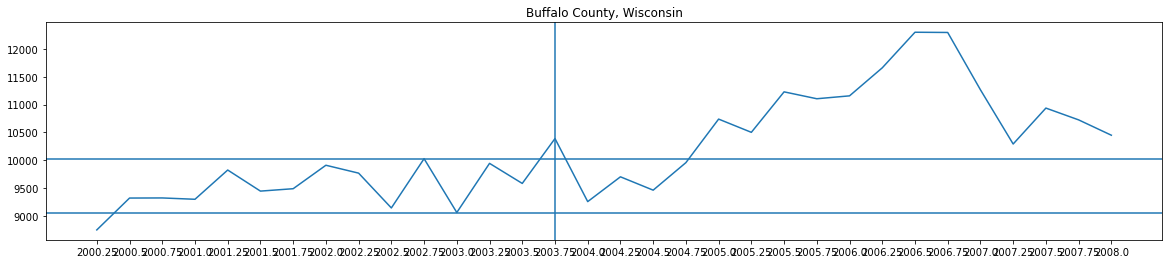

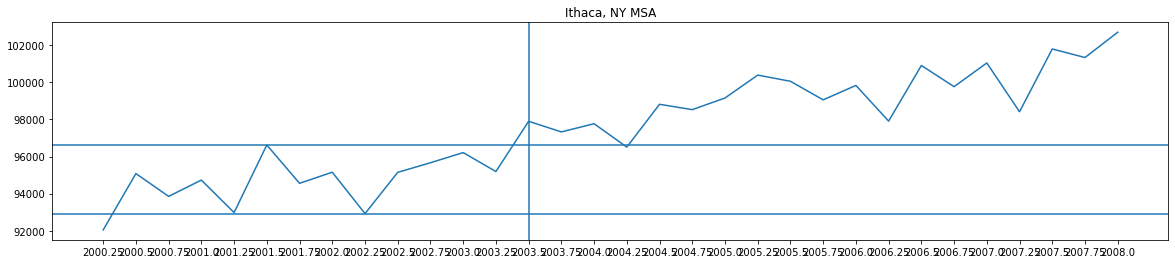

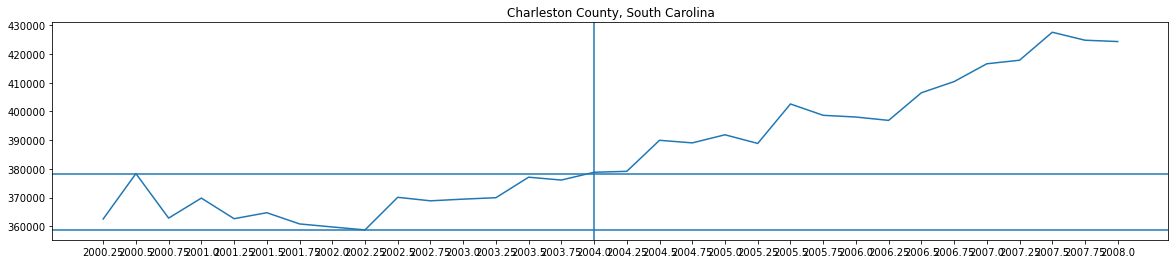

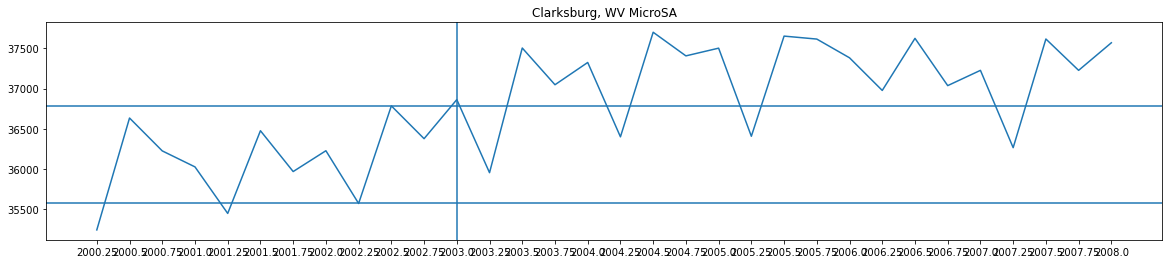

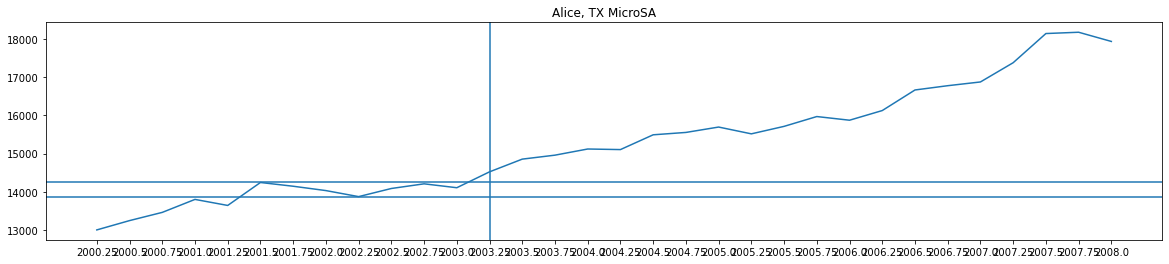

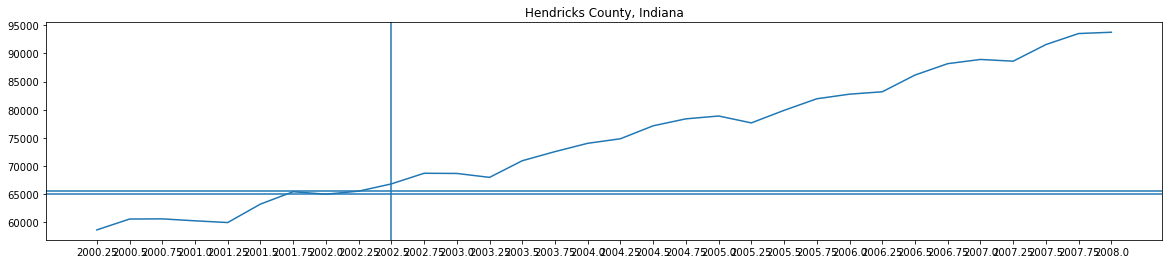

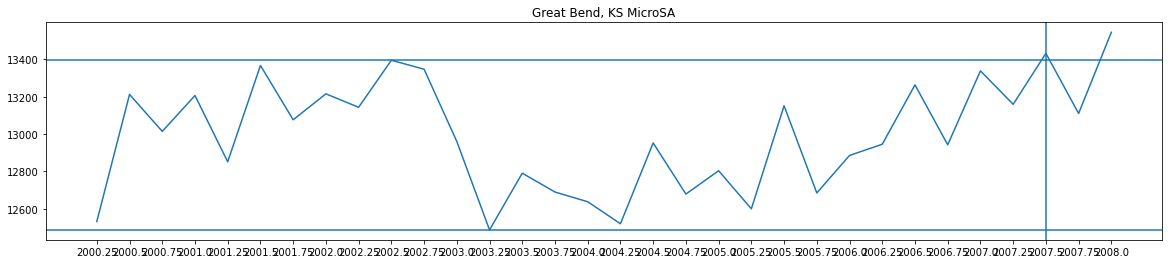

In [13]:
for check in range(0, 10):
    fig, ax = plt.subplots(figsize = (20,4))
    ax.plot(['2000.25', '2000.5', '2000.75', '2001.0', '2001.25', '2001.5', '2001.75', '2002.0', '2002.25', '2002.5', '2002.75', '2003.0', '2003.25', '2003.5','2003.75', '2004.0', '2004.25', '2004.5', '2004.75', '2005.0', '2005.25', '2005.5', '2005.75', '2006.0', '2006.25', '2006.5', '2006.75', '2007.0', '2007.25','2007.5', '2007.75', '2008.0'], df_plot.iloc[check])
    plt.title(df_samp['area_title'].iloc[check])
    ax.axhline(y =df_samp['nadir'].iloc[check])
    ax.axhline(y =df_samp['pre_peak'].iloc[check])
    ax.axvline(x = str(((df_samp['recovery_qtr'].iloc[check])  /4 ) + 2000.25))
    ax.legend;

In [14]:

# Python3 code to demonstrate  
# finding first True value  
# using filter() + lamda + index() 
  
# initializing list  
test_list = list(df_samp['recovery_list'][0]) 
  
# printing original list 
print ("The original list is : " + str(test_list)) 
  
# finding first True value 
# using filter() + lamda + index() 
res = test_list.index(next(filter(lambda i: i != 0, test_list))) 
  
# printing result 
print ("The values till first True value : " + str(res)) 


KeyError: 0

In [26]:

  
# printing original list 
print ("The original list is : " + str(test_list)) 
  
# finding first True value 
# using filter() + lamda + index() 
res = list(df_samp['recovery_list'][0]).index(next(filter(lambda i: i != 0, df_samp['recovery_list'][0])))
  
# printing result 
print ("The values till first True value : " + str(res)) 

NameError: name 'test_list' is not defined

In [ ]:
# biggest_vals = df_empl.transpose().iloc[0:8,:].max(axis=0)
# ending = (df_empl.transpose() > biggest_vals).idxmax()
# biggest_idx = df_wages.T.iloc[0:8,:].idxmax()